In [1]:
using JLD
using Plots
using Dates
using PyCall
using Random
using StatsBase
using Statistics
using BenchmarkTools
using DataFrames, IndexedTables
using Flux: onehot, onehotbatch, softmax, sigmoid
using BSON: @load, @save

system = "free_flyer"
include("$system/problem.jl")
include("$system/strategy_utils.jl")
include("$system/utils.jl")
include("$system/models.jl");

In [2]:
ENV["CUDA_VISIBLE_DEVICES"] = "0"

pushfirst!(PyVector(pyimport("sys")."path"), @__DIR__)
torch = pyimport("torch")
torch.cuda.empty_cache()
torchvision = pyimport("torchvision")
np = pyimport("numpy")
sns = pyimport("seaborn")

FFNet = pyimport("pytorch.models")."FFNet";

In [3]:
prob_files = [string("$system/data/testdata",ii,".jld") for ii=1:20] #filenames, choose 1-16 for training
prob_dicts = [load(f) for f in prob_files]

# Set problem specific features
prob_features = ["X0",  "obstacles"]

N = 6
n_obs = 8

# Calculate length of feature vector
feature_size = 0
if "X0" in prob_features
  feature_size += 4
end
if "obstacles" in prob_features
  feature_size += 4*n_obs
end
if "obstacles_map" in prob_features
  feature_size += n_obs*W*H
end
feature_size = Int(feature_size+=n_obs)

# Optimization problem handle
prob_handle = getObstacleAvoidanceProb

depth = 3
neurons = 128;

In [4]:
centers = Vector()
# push!(centers, [0.460; 0.315; 0.0])
# push!(centers, [0.540; 2.020; 0.0])
push!(centers, [0.201; 1.085; 0.0])
push!(centers, [1.374; 0.196; 0.0])
push!(centers, [1.063; 1.354; 0.0])
push!(centers, [1.365; 2.322; 0.0])
push!(centers, [2.221; 0.548; 0.0])
push!(centers, [2.077; 1.443; 0.0])
push!(centers, [3.098; 1.186; 0.0])
push!(centers, [2.837; 2.064; 0.0])

widths = [0.27; 0.27; 0.127]
inflation = 0.05*ones(3)

obstacles = []
for c in centers
    xmin,xmax = c[1]-0.5*widths[1]-inflation[1], c[1]+0.5*widths[1]+inflation[1]
    ymin,ymax = c[2]-0.5*widths[2]-inflation[2], c[2]+0.5*widths[2]+inflation[2]
    obstacle = [[xmin, xmax], [ymin, ymax]]
    push!(obstacles, obstacle)
end

In [5]:
fn_model = "model/mlopt_model_free_flyer_20200406_0927_3-layers_128-neurons.jld"

fn_dict = load(fn_model)
feature_size = fn_dict["feature_size"]
N_strategies = fn_dict["N_strategies"]
strategy_dict = fn_dict["strategy_dict"]

classifier_fn = replace(fn_model, ".jld"=>"_classifier.pt")
classifier_model = get_ff_classifier(feature_size, N_strategies; depth=depth,neurons=neurons)
classifier_model.load_state_dict(torch.load(classifier_fn))
n_evals = 2;

In [6]:
function solve_with_classifier(prob, x0, obstacles, prob_features, n_evals; max_evals=16)
    n_obs = length(obstacles)

    strategy_tuples = collect(Base.product([1:n_evals for _ in 1:n_obs]...))[:]
    prob_weights = [1/sum(strategy_tuple) for strategy_tuple in strategy_tuples]
    prob_weights = prob_weights ./ sum(prob_weights)
    strategy_tuples = unique([strategy_tuples[1];
                    sample(strategy_tuples, Weights(prob_weights), length(strategy_tuples), replace=false)])

    # Construct problem object
    y_binary = all_variables(prob)[is_binary.(all_variables(prob))]
    unset_binary.(y_binary) #relax so we solve LPs

    ind_max = zeros(n_evals,n_obs)
    prob_data = vcat(x0, 
        vcat([vcat(obstacles[ii]...) for ii in 1:n_obs]...))
    
    solve_time = 0.
    for ii_obs in 1:n_obs
        features = [onehot(ii_obs, 1:n_obs);
            construct_prob_features(fill(NaN,1), prob_data, prob_features)]
        input = torch.from_numpy(reshape(features,1,feature_size)).float()
        solve_time += @elapsed begin
            scores = classifier_model(input).cpu().detach().numpy()[:];
        end
        ind_max[:,ii_obs] = partialsortperm(scores, 1:n_evals, rev=true)
    end

    for (ii_eval,strategy_tuple) in enumerate(strategy_tuples[1:max_evals])
        y_guess = -1*ones(Int64,4*n_obs,N-1)

        for (k,v) in enumerate(strategy_dict)
            for ii_obs in 1:n_obs
                # First element of value will be index
                if ind_max[strategy_tuple[ii_obs],ii_obs] == v[2][1]
                    # Grab binary values for this strategy
                    y_guess[4*(ii_obs-1)+1:4*ii_obs,:] = reshape(deepcopy(v[2][2:end]),N-1,4)'
                end
            end
        end

        y_guess = round.(vectorizeIntegerData(y_guess))
        fix.(y_binary,y_guess, force=true)

        original_stdout = stdout
        (read_pipe, write_pipe) = redirect_stdout()
        optimize!(prob)
        redirect_stdout(original_stdout)
        close(write_pipe)
        solve_time += MOI.get(prob, MOI.SolveTime())

        if termination_status(prob) == MOI.OPTIMAL
            return true
        end
        unfix.(y_binary)
    end
    return false
end

solve_with_classifier (generic function with 1 method)

In [7]:
N = prob_dicts[1]["prob"]["N"]
A = prob_dicts[1]["prob"]["A"]
B = prob_dicts[1]["prob"]["B"]

posmin, posmax = prob_dicts[1]["prob"]["posmin"], prob_dicts[1]["prob"]["posmax"]
velmin, velmax = prob_dicts[1]["prob"]["velmin"], prob_dicts[1]["prob"]["velmax"]
umin, umax = prob_dicts[1]["prob"]["umin"], prob_dicts[1]["prob"]["umax"]
x0,xg = prob_dicts[1]["X0"][1], prob_dicts[1]["Xg"][1]
x0 = [0.5;0.5;-0.05;-0.05]
Q,R = prob_dicts[1]["prob"]["Q"], prob_dicts[1]["prob"]["R"]

# obstacles = prob_dicts[1]["O"][1]
prob, x, u, y, strategy_cons = obstacleAvoidanceProb(A, B, Q, R, N, 
    umin, umax, velmin, velmax, posmin, posmax, obstacles, x0, xg);

In [8]:
traj = zeros(Float64,length(x0),0)
traj = hcat(traj, x0)
for ii in 1:20
    if !solve_with_classifier(prob, x0, obstacles, prob_features, n_evals)
        @warn "Failed!"
    end

    u0 = value.(u)[:,1]
    x0 = A*x0 + B*u0
    traj = hcat(traj, x0)

    prob, x, u, y, strategy_cons = obstacleAvoidanceProb(A, B, Q, R, N, 
        umin, umax, velmin, velmax, posmin, posmax, obstacles, x0, xg);
end

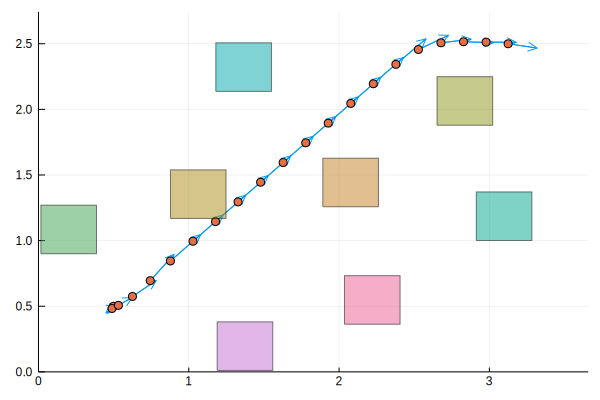

In [9]:
rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])

Plots.quiver(traj[1,:], traj[2,:], gradient=(traj[3,:], traj[4,:]))
Plots.scatter!(traj[1,:], traj[2,:])
for oo in obstacles[1:end-1]
    Plots.plot!(rectangle(oo[1][2]-oo[1][1],oo[2][2]-oo[2][1],oo[1][1], oo[2][1]), opacity=0.5, legend=false)
end
oo = obstacles[end]
Plots.plot!(rectangle(oo[1][2]-oo[1][1],oo[2][2]-oo[2][1],oo[1][1], oo[2][1]), opacity=0.5, legend=false,
    xaxis=("", (0,posmax[1])),yaxis=("", (0,posmax[2])))

# Use MeshCat for simulation

In [ ]:
using AstrobeeRobot
using GeometryTypes
using GeometryTypes: Point3, HyperSphere, HyperRectangle
using MeshCat, MeshCatMechanisms, CoordinateTransformations
import ColorTypes: RGBA

include("table.jl")
include("robot.jl");

In [ ]:
robot = Freeflyer()
env = Table(:stanford)

widths = [0.27; 0.27; 0.127]
inflation = 0.05*ones(3)

for idx in 1:length(centers)
    push!(env.obstacle_set, HyperRectangle(Vec3f0(centers[idx]-0.5*widths-inflation+[0.;0.;0.5*widths[1]]), Vec3f0(widths+2*inflation)))
end

In [ ]:
vis = Visualizer()
delete!(vis)

vis[:goal]
for (idx,obs) in enumerate(env.keepout_zones)
    setobject!(vis[:goal][:goal], 
        Object(HyperSphere(Point3(0.9*env.worldAABBmax), 0.1),
            MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))
end

vis[:table]
table_dim = env.worldAABBmax-env.worldAABBmin
setobject!(vis[:table][:table], 
        Object(HyperRectangle(env.worldAABBmin..., table_dim...),
            MeshBasicMaterial(color=RGBA(0,1.0,0.,0.3))))

# vis[:workspace]
# for (idx,ws) in enumerate(env.keepin_zones)
#     if idx in (5,8)
#         setobject!(vis[:workspace][Symbol(string("ws",idx))],
#             Object(ws, MeshBasicMaterial(color=RGBA(0.95,0.93,0.26,0.3), depthWrite=false)))
#     else
#         setobject!(vis[:workspace][Symbol(string("ws",idx))],
#             Object(ws, MeshBasicMaterial(color=RGBA(0.95,0.93,0.26,0.3))))
#     end
# end

vis[:obstacles]
for (idx,obs) in enumerate(env.obstacle_set)
    setobject!(vis[:obstacles][Symbol(string("obs",idx))], 
        Object(obs,MeshBasicMaterial(color=RGBA(1.0,0.,0.,0.3))))
end

ab = Astrobee()
# mvis = MechanismVisualizer(
#     ab.mechanism,
#     URDFVisuals(AstrobeeRobot.urdfpath(), package_path=[dirname(dirname(AstrobeeRobot.urdfpath()))]),
#     vis);

vis[:robot]
setobject!(vis[:robot][:base],
    Object(Cylinder(Point3f0(0,0,0.),Point3f0(0.,0.,0.5),Float32(robot.r)),MeshBasicMaterial(color=RGBA(0,0.,1.,0.7))))

speed_factor = 1


# Qs = Vector{Float64}[]
# for k in 1:speed_factor:N
#     q = [0;0;0;1.; X[1:2,k]; -robot.r]
#     push!(Qs,q)
# end

sleep(3)
# setanimation!(mvis,1:length(Qs),Qs)

plot_in_cell = false
plot_in_cell ? IJuliaCell(vis) : open(vis)